In [51]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

from statsmodels.stats.multicomp import pairwise_tukeyhsd

import re
import nltk


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from datetime import datetime

import xgboost as xgb

In [2]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

In [24]:
def clear():
    os.system('cls')

def ListNoDups(mylist):
    mylist = list(dict.fromkeys(mylist))
    return mylist

def CleanList(list_to_clean, len_less_than = 3):
    cleaned_list = [x for x in list_to_clean if str(x) != 'nan' and len(x) >= len_less_than ]
    return cleaned_list

class CarData:
    
    missing = -1
    duplicates = -1
    
    price_outliers = -1
    mileage_outliers = -1
    year_outliers = -1
    total_discard = -1
    
    corpus = []
    def __init__(self, path, price_outlier_mt = 200000, mileage_outlier_mt = 400000,
                year_outlier_lt = 1995, engine_outlier_mt = 4000, engine_outlier_lt = 750,
                dependent_variable = 'price',
                categorical_variables = ['engine_type', 'city', 'province'],
                numeric_variables = ['price', 'mileage_km', 'engine_cm3', 'year']):
        
        #define outliers values
        self.price_outlier_mt = price_outlier_mt
        self.mileage_outlier_mt = mileage_outlier_mt
        self.year_outlier_lt =  year_outlier_lt
        self.engine_outlier_mt = engine_outlier_mt
        self.engine_outlier_lt = engine_outlier_lt
        self.dependent_variable = dependent_variable
        

        
        
        #define variable data types
        self.numeric_variables = numeric_variables
        self.categorical_variables = categorical_variables
        
        #read all .csv files from the directory
        self.data = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))), sort=False)
        
        #drop the duplicates and save the number of duplicates - many duplicates due to data gathering method
        self.duplicates = len(self.data) - len(self.data.drop_duplicates())
        self.data.drop_duplicates(inplace = True)
        
        #rename columns
        self.data.columns = ['title', 'price', 'sub_title', 'mileage_km', 'year', 'engine_cm3',
                'engine_type', 'city', 'province', 'negotiable']
        
        #drop NaNs and save the number of rows dropped to the missing varaible
        self.missing = self.data['engine_type'].isna().sum()
        self.data.dropna(subset = ['engine_type'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['city'].isna().sum()
        self.data.dropna(subset = ['city'], axis = 'index', inplace = True)
        
        self.missing = self.missing + self.data['engine_cm3'].isna().sum()
        self.data.dropna(subset = ['engine_cm3'], axis = 'index', inplace = True)
        
        #clean up the columns
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(",", ""))
        self.data['price'] = self.data['price'].apply(lambda x: x.replace(" ", "")).astype('int')
        
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace("km", ""))
        self.data['mileage_km'] = self.data['mileage_km'].apply(lambda x: x.replace(" ", "")).astype('float')
        
        self.data['engine_cm3'] = self.data['engine_cm3'].astype('str')
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace('cm3', ''))
        self.data['engine_cm3'] = self.data['engine_cm3'].apply(lambda x: x.replace(' ','')).astype('int')
        
        self.data['province'] = self.data['province'].astype('str')
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('(',''))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace(')',''))
        
        self.data['sub_title'] = self.data['sub_title'].astype('str') #may change that in the future - possible info loss due to lowercase
        
        
        self.data['title'] = self.data['title'].astype('str') #may change that in the future - possible info loss due to lowercase
        
        self.data['negotiable'] = self.data['negotiable'].astype('str')
        
        #Add ID column
        self.data.insert(loc = 0, column = 'ID', value = range(1, len(self.data)+1))

        #discard outliers and calculate the numbers
        self.total_discard = len(self.data) - len(self.data[(self.data['price'] <= self.price_outlier_mt) &
                                                        (self.data['mileage_km'] <= self.mileage_outlier_mt) &
                                                        (self.data['year'] >= self.year_outlier_lt) &
                                                        (self.data['engine_cm3'] <= self.engine_outlier_mt) &
                                                        (self.data['engine_cm3'] >= self.engine_outlier_lt)])        
        
        self.price_outliers = len(self.data[self.data['price'] > price_outlier_mt])
        self.data = self.data[self.data['price'] <= price_outlier_mt]
        
        self.mileage_outliers = len(self.data[self.data['mileage_km'] > mileage_outlier_mt])
        self.data = self.data[self.data['mileage_km'] <= mileage_outlier_mt]
        
        self.year_outliers = len(self.data[self.data['year'] < year_outlier_lt])
        self.data = self.data[self.data['year'] >= year_outlier_lt]
        
        self.engine_outliers = len(self.data[(self.data['engine_cm3'] > engine_outlier_mt) |
                                            (self.data['engine_cm3'] < engine_outlier_lt)])
        self.data = self.data[(self.data['engine_cm3'] <= engine_outlier_mt) & 
                             (self.data['engine_cm3'] >= engine_outlier_lt)]
        
        #NLP
        self.data['concat_title_subtitle'] = self.data['title'] + ' ' + self.data['sub_title']
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.lower())
        
        #replace problematic cases for NLP for title and subtitle
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('+',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('(',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace(')',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('**',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('*',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace(']',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('[',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace("/"," "))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace("\\"," "))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace(',',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('?',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('.',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('!',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('_',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('-',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('|',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('#',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('%',' '))
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('~',' '))  
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('*',' ')) 
        self.data['concat_title_subtitle'] = self.data['concat_title_subtitle'].apply(lambda x: x.replace('*',' '))
        
        #NLP preprocessing for location
        self.data['province'] = self.data['province'].apply(lambda x: x.lower()) 
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ą', 'a')) 
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ę', 'e'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ł', 'l'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ś', 's'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ć', 'c'))
        self.data['province'] = self.data['province'].apply(lambda x: x.replace('ż', 'z'))
        
    def describe(self):
        #descriptive statistice
        desc_stats = round(pd.DataFrame(
                        data = self.data[self.numerical_variables].describe(),
                        columns = self.data[self.numerical_variables].columns),2)
        return desc_stats
    
    def outliers(self):
        #baisc data about outliers discarded during preprocessing
        print('Offers with price greater than '+str(self.price_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.price_outliers))
        print('')
        print('Offers with mileage greater than '+str(self.mileage_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.mileage_outliers))
        print('')
        print('Offers with year lower than '+str(self.year_outlier_lt)+' have been discarded')
        print('The number of such offers = '+str(self.year_outliers))
        print('')
        print('Offers with engine_cm3 greater than '+str(self.engine_outlier_lt)+
              ' and lower than '+str(self.engine_outlier_mt)+' have been discarded')
        print('The number of such offers = '+str(self.engine_outliers))
        print('')
        print('Total number of discarded offers = '+str(self.total_discard)
              +'('+str(round(self.total_discard/len(self.data)*100,2))+'%)'
              +' - may be different to the sum of above due to overlap')
        
    def scatter_nox(self, var = 'all', figsize_1 = 7, figsize_2 = 5):
        #prints scatter plots with no x axis - a dummy sequence as x axis
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        if var == 'all':
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data['mileage_km'], x = range(1, len(self.data)+1), s=1)
            plt.title('mileage_km')
            plt.show()

            plt.scatter(y = self.data['price'], x = range(1, len(self.data)+1), s=1)
            plt.title('price')
            plt.show()

            plt.scatter(y = self.data['year'], x = range(1, len(self.data)+1), s=1)
            plt.title('year')
            plt.show()

            plt.scatter(y = self.data['engine_cm3'], x = range(1, len(self.data)+1), s=1)
            plt.title('engine_cm3')
            plt.show()
        else:
            plt.rcParams["figure.figsize"] = (figsize_1,figsize_2)
            plt.scatter(y = self.data[var], x = range(1, len(self.data)+1), s=1)
            plt.title(var)
            plt.show()
            
    def scatter(self, var = 'all'):
        #prints scatter plots for numerical variables
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        list_comb = []
        if var == 'all':
            for variable1 in enumerate(self.numeric_variables):
                for variable2 in enumerate(self.numeric_variables):
                    if variable1 != variable2 and variable1[1]+variable2[1] not in list_comb and variable2[1]+variable1[1] not in list_comb:
                        plt.scatter(y = self.data[variable1[1]], x = self.data[variable2[1]], s=1)
                        plt.title("Correlation between "+variable1[1]+' and '+variable2[1])
                        plt.ylabel(variable1[1])
                        plt.xlabel(variable2[1])
                        plt.show()
                        list_comb.append(variable1[1]+variable2[1])
        #else: - TO DO
    
    def hist(self, var = 'all', bins = 50):
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        #prints histograms for numeric variables
        if var == 'all':
            for variable in enumerate(self.numeric_variables):
                plt.hist(x = self.data[variable[1]], bins = bins)
                plt.title(variable[1])
                plt.show()
     
    def price_cat_vars(self, variables = '_NULL_'):
        
        if variables == '_NULL_':
            variables = self.categorical_variables
            
        for variable in enumerate(variables):
            # shows desrptive statistics of categorical variables
            print(self.data.groupby(self.data[variable[1]])['price'].describe())
            #the variables need further preprocessing
            
    def add_dummies(self, columns_to_check, categorical_list = '_NULL_', delete_from_strings = 'yes', delete_column = 'no'):
        #adds dummmies from cat_list, checks in every column of columns_to_check

        for column in enumerate(columns_to_check):            
            if categorical_list == '_NULL_':
                categorical_list = data.data[column[1]].unique().tolist()
            
            for category in enumerate(categorical_list):
                col_name = column[1] + '_' + category[1]
                self.data[col_name] = self.data[column[1]].str.contains(category[1]).astype('int')
                
                #append newly craeted variables to categorical variables
                if self.data[col_name].sum() > 0:
                    self.categorical_variables.append(col_name)
                else:
                    self.data.drop(columns = [col_name], inplace = True)
                
                #delete the string from the column
                if delete_from_strings == 'yes':
                    self.data[column[1]] = self.data[column[1]].apply(lambda x: x.replace(category[1], ''))
                    
            #delete the column
            if delete_column == 'yes':
                self.data.drop(columns = column[1], inplace = True)
                
        return self
    
    def add_dummies2(self, categorical_list, delete_from_column = 'yes', delete_concat_column = 'no', column = 'concat_title_subtitle'):
        #adds dummmies from cat_list, checks in concat_title_subtitle column
        for category in enumerate(categorical_list):
            
            #print(category)
            
            col_name = category[1]
            self.data[col_name] = self.data[column].str.contains(category[1]).astype('int')
                
                #append newly craeted varaibles to categorical variables
            if self.data[col_name].sum() > 0:
                self.categorical_variables.append(col_name)
            else:
                self.data.drop(columns = [col_name], inplace = True)
                
                #delete the string from the column
            if delete_from_column == 'yes':
                self.data[column] = self.data[column].apply(lambda x: x.replace(category[1], ''))
                                                
            if delete_concat_column == 'yes':
                self.data.drop(columns = column, inplace = True)
                
        return self
    """
    def ind_test(self, var, alpha = 0.05):
        if alpha > 1 or alpha < 0:
            print('Incorrect alpha value. Select a value from <0;1>.')
            
        if var != 'all' and var not in self.data.columns:
            print('Variable not found in the dataset')
        pivot = round(self.data.pivot_table(values = 'price', index = var, aggfunc = ['count', 'mean']),2)
        pivot.columns = ['count', 'mean']
        
        mean_price = self.data['price'].mean()
        
        pivot['sm'] = pivot['mean']/((pivot['count'])**(1/2))
        
        pivot['t'] = (pivot['mean']-mean_price)/pivot['sm']
        pivot['df'] = pivot['count']-1

        #calculate p-value
        pivot['t_border'] = stats.t.ppf(1-alpha/2, pivot['df'])
        
        #implementation here is not 100% mathematically correct
        return pivot
    """
    def anova(self, var = 'all', alpha = 0.05):
        if var == 'all':
            for variable in enumerate(self.categorical_variables):
                anova_data = self.data[[variable[1], 'price']].reset_index().copy()
                anova_data.columns = ['index', variable[1], 'price']
                equation_string = 'price ~ '+str(variable[1])
                model = ols(equation_string, data=anova_data).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                print(anova_table)
                print()
                
                #pairwise comparisons
                pairwise_comparison = pairwise_tukeyhsd(endog = anova_data['price'],
                                                        groups = anova_data[variable[1]],
                                                        alpha = alpha)
                print(pairwise_comparison)
                print()
        #else:
            #TO DO
            #also TO DO check Anova assumptions
    def make_corpus(self, column = 'concat_title_subtitle'):
        #creates a corpus out of title and subtitle column
        for i in range(0, len(self.data)):
            #string = re.sub('[^a-zA-Z]', ' ', self.data.reset_index().loc[i]['concat_title_subtitle'])
            string = self.data.reset_index().loc[i][column]
            string = string.split()
            self.corpus = self.corpus + string
        self.corpus = ListNoDups(self.corpus)
        
        #with open("corpus.txt", "w") as output:
         #   output.write(str(self.corpus))
    
        return self.corpus
    
    def analyse_variables(self, list_of_variables, discard = 0.01):
    # independence tests for a list of variable e.g. corpus
        final_df = pd.DataFrame(columns = ['variable', 'mean_1', 'mean_0', 'count_1', 'count_0'])

        for variable in enumerate(list_of_variables):
            #debug
            #print(str(variable)+' done')
            
            self.data[variable[1]] = self.data['concat_title_subtitle'].str.contains(variable[1]).astype('int')

            mean_1 = self.data.loc[self.data[variable[1]] == 1][self.dependent_variable].mean()
            mean_0 = self.data.loc[self.data[variable[1]] == 0][self.dependent_variable].mean()

            count_1 = len(self.data.loc[self.data[variable[1]] == 1])
            count_0 = len(self.data.loc[self.data[variable[1]] == 0])        
            
            if count_1 >= discard * len(self.data) and count_0 >= discard * len(self.data):            
                dict_to_append = {
                    'variable' : variable[1],
                    'mean_1' : mean_1,
                    'mean_0' : mean_0,
                    'count_1' : count_1,
                    'count_0' : count_0
                }

                final_df = final_df.append(dict_to_append, ignore_index = True)

            self.data.drop(columns = [variable[1]], inplace = True)

            #if variable[0] % 1000 == 0:
            #    print(str(variable[0])+'/'+str(len(list_of_variables)))         
            
        
        
        final_df['mean_diff'] = abs(final_df['mean_1'] - final_df['mean_0'])
        final_df = final_df.sort_values(by = 'mean_diff', ascending = False).reset_index()
        final_df.drop(columns = 'index', inplace = True)
        
        date = datetime.date(datetime.now())
        
        final_df.to_csv('analyse_variables_'+str(date)+'.csv')
        
        return final_df

        
            

#cv = CountVectorizer(max_features = 1000)
#X = cv.fit_transform(corpus).toarray()

In [25]:
data = CarData(path = 'data/', dependent_variable = 'price', categorical_variables = ['engine_type', 'city', 'province'],
           numeric_variables = ['price', 'mileage_km', 'engine_cm3', 'year'])

brands = ['alfa', 'audi', 'bmw', 'chevrolet', 'chrysler',
          'citroen', 'dacia', 'daewoo', 'dodge', 'fiat',
          'ford', 'honda', 'hyundai', 'jaguar', 'jeep',
         'kia', 'rover', 'lexus', 'mazda', 'mercedes',
         'mitsubishi', 'nissan', 'opel', 'peugeot',
         'porsche', 'renault', 'seat', 'smart', 'subaru', 
          'suzuki', 'tesla', 'toyota', 'volkswagen',
          'volvo', 'skoda']

In [26]:
data.add_dummies2(brands)

In [6]:
corpus = x.make_corpus()

In [33]:
analysis = x.analyse_variables(corpus, discard = 0.01)

In [11]:
analysis = pd.read_csv('analyse_variables_results.csv', index_col=0)

In [27]:
variables = analysis['variable'].values.tolist()
cleaned_variables = CleanList(list_to_clean = variables, len_less_than = 3)

In [28]:
data.add_dummies2(cleaned_variables)

In [29]:
data.data.head()

,ID,title,price,sub_title,mileage_km,year,engine_cm3,engine_type,city,province,negotiable,concat_title_subtitle,alfa,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,dodge,fiat,ford,honda,hyundai,jaguar,jeep,kia,rover,lexus,mazda,mercedes,mitsubishi,nissan,opel,peugeot,porsche,renault,seat,smart,subaru,suzuki,tesla,toyota,volkswagen,volvo,skoda,drive,fv23,v23,20d,pakiet,akiet,pak,dsg,vat,quattro,quat,fort,line,for,akt,kam,amer,fak,led,lin,tsi,pre,salon,klimatyzacj,sal,ful,corsa,180,tyl,raw,polo,klima,klim,aso,tiv,ima,16v,elektr,gaz,drzw,drz,fabia,opłat,lim,50km,0td,sport,elekt,niemie,sprowadzon,spro,150k,asa,elek,wad,lpg,clio,niem,fiesta,fiest,dobry,ład,opł,201,200,4x4,polska,spr,alufelgi,zadbana,pano,benzyn,benzy,150,enzyna,alufelg,alufel,klas,sce,zadb,90km,ram,man,bdb,105,felgi,gwa,tec,citroën,felg,spo,focus,picasso,astra,megan,jak,pcja,astr,zarejestr,zarejest,zarej,yaris,krajowy,qashqai,qashqa,rejestrowany,reje,ora,jest,nav,iii,pic,kombi,mega,zar,opc,tronik,dam,con,polski,dti,bard,krajow,tom,alu,aut,seria,seri,ara,pan,rej,nie,hdi,str,szyb,kom,golf,przed,polecam,poleca,kraj,gol,nowy,ins,naw,sta,kóra,pierwszy,wszy,titanium,wers,wer,rav,peł,oryginal,pol,pier,fab,okazja,okaz,orygi,skó,oryg,tra,prz,grand,110,lift,wyp,000,super,sup,avant,diesel,diese,rok,lif,turb,dach,wła,pas,bezw,100,tron,idea,cic,tys,ser,tyś,tdci,dci,tour,tempo,tdc,osob,bieg,140,zamia,mały,cam,zam,oso,pryw,ory,bie,avensis,nic,monde,tel,xen,ben,enon,oro,cja,gran,mat,temp,crd,bog,sel,tdi,kod,40km,120,park,tem,130,pro,fote,tani,fot,pdc,grza,170,par,sat,octavia,octavi,max,van,sto,pod,cta,ass,ele,szy,bez,ani,nisk,grz,and,kier
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Benzyna,Katowice,slaskie,nan,cx 3 1 6at skysion biala s safety i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Diesel,Garbatka-Letnisko,mazowieckie,Do negocjacji,tner ay dokumenta eu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Benzyna,Garbatka-Letnisko,mazowieckie,Do negocjacji,age aa napęd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Škoda Roomster,12900,Opłacona~Serwis ASO~Klimatronic~Grzane siedzenia,238000.0,2006,1600,Benzyna,Garbatka-Letnisko,mazowieckie,Do negocjacji,ša roomster aa wis ic ne siedzenia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
data.add_dummies(columns_to_check = ['engine_type'],  delete_column = 'yes')

In [31]:
data.add_dummies(columns_to_check = ['province'], delete_column = 'yes')

In [35]:
data.data

,ID,title,price,sub_title,mileage_km,year,engine_cm3,city,negotiable,concat_title_subtitle,alfa,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,dodge,fiat,ford,honda,hyundai,jaguar,jeep,kia,rover,lexus,mazda,mercedes,mitsubishi,nissan,opel,peugeot,porsche,renault,seat,smart,subaru,suzuki,tesla,toyota,volkswagen,volvo,skoda,drive,fv23,v23,20d,pakiet,akiet,pak,dsg,vat,quattro,quat,fort,line,for,akt,kam,amer,fak,led,lin,tsi,pre,salon,klimatyzacj,sal,ful,corsa,180,tyl,raw,polo,klima,klim,aso,tiv,ima,16v,elektr,gaz,drzw,drz,fabia,opłat,lim,50km,0td,sport,elekt,niemie,sprowadzon,spro,150k,asa,elek,wad,lpg,clio,niem,fiesta,fiest,dobry,ład,opł,201,200,4x4,polska,spr,alufelgi,zadbana,pano,benzyn,benzy,150,enzyna,alufelg,alufel,klas,sce,zadb,90km,ram,man,bdb,105,felgi,gwa,tec,citroën,felg,spo,focus,picasso,astra,megan,jak,pcja,astr,zarejestr,zarejest,zarej,yaris,krajowy,qashqai,qashqa,rejestrowany,reje,ora,jest,nav,iii,pic,kombi,mega,zar,opc,tronik,dam,con,polski,dti,bard,krajow,tom,alu,aut,seria,seri,ara,pan,rej,nie,hdi,str,szyb,kom,golf,przed,polecam,poleca,kraj,gol,nowy,ins,naw,sta,kóra,pierwszy,wszy,titanium,wers,wer,rav,peł,oryginal,pol,pier,fab,okazja,okaz,orygi,skó,oryg,tra,prz,grand,110,lift,wyp,000,super,sup,avant,diesel,diese,rok,lif,turb,dach,wła,pas,bezw,100,tron,idea,cic,tys,ser,tyś,tdci,dci,tour,tempo,tdc,osob,bieg,140,zamia,mały,cam,zam,oso,pryw,ory,bie,avensis,nic,monde,tel,xen,ben,enon,oro,cja,gran,mat,temp,crd,bog,sel,tdi,kod,40km,120,park,tem,130,pro,fote,tani,fot,pdc,grza,170,par,sat,octavia,octavi,max,van,sto,pod,cta,ass,ele,szy,bez,ani,nisk,grz,and,kier,engine_type_Benzyna,engine_type_Diesel,engine_type_Hybryda,engine_type_Elektryczny,province_slaskie,province_mazowieckie,province_lódzkie,province_lubelskie,province_malopolskie,province_wielkopolskie,province_warmińsko-mazurskie,province_lubuskie,province_kujawsko-pomorskie,province_podlaskie,province_podkarpackie,province_pomorskie,province_opolskie,province_swietokrzyskie,province_region midtjylland,province_zylina,province_moravian-silesian region,province_noord-brabant,province_wilno,province_noord-holland,province_region hovestaden,province_nordrhein-westfalen,province_languedoc-roussillon-midi-pyrénées,province_hessen,province_berlin,province_niedersachsen
0,1,Mazda CX-3,69700,150KM 6AT 4x4 SkyPASSION (+ Biala skóra + Safe...,51015.0,2015,1998,Katowice,nan,cx 3 1 6at skysion biala s safety i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Peugeot Partner,19500,Opłacony~Dokumentacja Przebiegu,180000.0,2009,1600,Garbatka-Letnisko,Do negocjacji,tner ay dokumenta eu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Kia Sportage,26800,Opłacona~Napęd 4x4,165000.0,2009,2000,Garbatka-Letnisko,Do negocjacji,age aa napęd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [33]:
date = datetime.date(datetime.now())
data.data.to_csv('data_'+str(date)+'.csv')

In [41]:
y = data.data['price'].copy()

In [43]:
X = pd.concat([data.data.iloc[: , [4,5,6]], data.data.iloc[: , 10:]], axis = 1, sort = False)

In [45]:
stand_scale = StandardScaler()

In [46]:
X_scaled = stand_scale.fit_transform(X)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

## Logistic Regression

In [33]:
lin_reg = LogisticRegression()

In [ ]:
lin_reg.fit(X_scaled, y)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
y_pred = lin_reg.predict(y)

## Gradient Boosting

In [52]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [112]:
param = {'max_depth': 6,
        'learning_rate': 0.1,        
        'nthread': 8,
         'tree_method': 'gpu_hist',
        'eval_metric': ['rmse', 'mae']}
evallist = [(dtest, 'test'), (dtrain, 'train')]
num_round = 1700

In [113]:
bst = xgb.train(param, dtrain, num_round, evals = evallist)

[0]	test-rmse:39675.94531	test-mae:28297.30273	train-rmse:40098.59375	train-mae:28662.97461
[1]	test-rmse:36297.21875	test-mae:25488.22070	train-rmse:36681.02734	train-mae:25818.07031
[2]	test-rmse:33279.00391	test-mae:22974.48242	train-rmse:33642.41016	train-mae:23282.50781
[3]	test-rmse:30594.77930	test-mae:20746.37305	train-rmse:30939.15430	train-mae:21031.46680
[4]	test-rmse:28247.54492	test-mae:18783.50586	train-rmse:28551.46875	train-mae:19043.08594
[5]	test-rmse:26142.73438	test-mae:17051.30859	train-rmse:26439.69141	train-mae:17301.18555
[6]	test-rmse:24329.16406	test-mae:15547.61035	train-rmse:24588.63672	train-mae:15788.85156
[7]	test-rmse:22725.92383	test-mae:14248.44043	train-rmse:22951.54492	train-mae:14475.86523
[8]	test-rmse:21308.62891	test-mae:13126.25098	train-rmse:21517.27148	train-mae:13346.72363
[9]	test-rmse:20078.79492	test-mae:12166.27734	train-rmse:20277.57031	train-mae:12383.48926
[10]	test-rmse:19000.06836	test-mae:11350.14941	train-rmse:19193.89844	train-mae

[90]	test-rmse:11905.24219	test-mae:6680.95654	train-rmse:10998.25195	train-mae:6468.86230
[91]	test-rmse:11895.53320	test-mae:6674.46240	train-rmse:10983.30176	train-mae:6459.69824
[92]	test-rmse:11890.31152	test-mae:6667.28418	train-rmse:10971.49414	train-mae:6451.01904
[93]	test-rmse:11883.40820	test-mae:6661.43555	train-rmse:10960.20898	train-mae:6442.42188
[94]	test-rmse:11878.19336	test-mae:6654.41504	train-rmse:10951.28809	train-mae:6433.21582
[95]	test-rmse:11876.58496	test-mae:6653.06836	train-rmse:10943.40039	train-mae:6429.03272
[96]	test-rmse:11874.80762	test-mae:6651.53418	train-rmse:10929.75781	train-mae:6422.16797
[97]	test-rmse:11871.58398	test-mae:6646.98926	train-rmse:10923.74609	train-mae:6416.60352
[98]	test-rmse:11870.22754	test-mae:6644.74023	train-rmse:10919.83594	train-mae:6413.37158
[99]	test-rmse:11868.10644	test-mae:6642.72363	train-rmse:10909.26269	train-mae:6409.23682
[100]	test-rmse:11864.09473	test-mae:6638.74805	train-rmse:10902.70215	train-mae:6404.1337

[180]	test-rmse:11610.42481	test-mae:6420.40381	train-rmse:10288.99023	train-mae:6029.40039
[181]	test-rmse:11605.93750	test-mae:6418.34473	train-rmse:10283.84766	train-mae:6025.51660
[182]	test-rmse:11603.14062	test-mae:6414.62549	train-rmse:10276.75781	train-mae:6019.09570
[183]	test-rmse:11599.43262	test-mae:6412.15283	train-rmse:10267.11231	train-mae:6013.58643
[184]	test-rmse:11598.01074	test-mae:6411.00195	train-rmse:10264.89648	train-mae:6011.45654
[185]	test-rmse:11596.92676	test-mae:6409.24023	train-rmse:10260.81641	train-mae:6008.20264
[186]	test-rmse:11595.94434	test-mae:6408.37158	train-rmse:10256.30762	train-mae:6005.55811
[187]	test-rmse:11593.36816	test-mae:6406.67432	train-rmse:10245.66211	train-mae:6000.20410
[188]	test-rmse:11592.60938	test-mae:6406.11377	train-rmse:10243.07227	train-mae:5997.76562
[189]	test-rmse:11594.64551	test-mae:6404.47314	train-rmse:10234.45410	train-mae:5993.86377
[190]	test-rmse:11589.76660	test-mae:6401.98096	train-rmse:10223.11231	train-mae

[270]	test-rmse:11489.59082	test-mae:6306.47754	train-rmse:9823.13477	train-mae:5756.10303
[271]	test-rmse:11489.22266	test-mae:6306.38135	train-rmse:9818.97949	train-mae:5753.79443
[272]	test-rmse:11486.66113	test-mae:6303.22559	train-rmse:9814.92871	train-mae:5750.18506
[273]	test-rmse:11487.37891	test-mae:6303.76025	train-rmse:9808.60254	train-mae:5747.09277
[274]	test-rmse:11484.19043	test-mae:6301.60156	train-rmse:9802.70801	train-mae:5743.77197
[275]	test-rmse:11483.28516	test-mae:6300.12939	train-rmse:9800.37598	train-mae:5742.14990
[276]	test-rmse:11480.34082	test-mae:6298.19678	train-rmse:9791.88867	train-mae:5737.50195
[277]	test-rmse:11476.97656	test-mae:6295.86914	train-rmse:9786.05957	train-mae:5734.30127
[278]	test-rmse:11476.70019	test-mae:6295.70459	train-rmse:9785.10840	train-mae:5733.77637
[279]	test-rmse:11475.11035	test-mae:6293.97363	train-rmse:9780.93945	train-mae:5730.13525
[280]	test-rmse:11474.53906	test-mae:6293.85352	train-rmse:9776.67578	train-mae:5727.99121

[361]	test-rmse:11393.08106	test-mae:6221.61816	train-rmse:9455.04394	train-mae:5540.66943
[362]	test-rmse:11392.95898	test-mae:6221.84131	train-rmse:9449.71680	train-mae:5538.73291
[363]	test-rmse:11392.76758	test-mae:6221.75098	train-rmse:9447.18652	train-mae:5536.86279
[364]	test-rmse:11393.05957	test-mae:6221.68506	train-rmse:9446.43555	train-mae:5536.26367
[365]	test-rmse:11394.55957	test-mae:6221.46875	train-rmse:9440.99609	train-mae:5533.07129
[366]	test-rmse:11394.05176	test-mae:6221.06250	train-rmse:9439.54785	train-mae:5531.87598
[367]	test-rmse:11390.98340	test-mae:6219.63818	train-rmse:9435.99121	train-mae:5529.85205
[368]	test-rmse:11388.84863	test-mae:6217.67529	train-rmse:9433.12891	train-mae:5527.34277
[369]	test-rmse:11387.61914	test-mae:6217.18945	train-rmse:9429.37598	train-mae:5525.16650
[370]	test-rmse:11386.86719	test-mae:6216.78857	train-rmse:9423.88672	train-mae:5522.69043
[371]	test-rmse:11385.20703	test-mae:6214.95459	train-rmse:9420.38867	train-mae:5519.27246

[452]	test-rmse:11313.48828	test-mae:6157.50928	train-rmse:9129.01953	train-mae:5353.48730
[453]	test-rmse:11313.46484	test-mae:6157.33447	train-rmse:9127.72949	train-mae:5352.49561
[454]	test-rmse:11313.63867	test-mae:6157.70215	train-rmse:9127.12793	train-mae:5352.14844
[455]	test-rmse:11313.85352	test-mae:6157.73145	train-rmse:9126.93164	train-mae:5351.97070
[456]	test-rmse:11313.81445	test-mae:6157.35156	train-rmse:9124.57031	train-mae:5350.58203
[457]	test-rmse:11313.92188	test-mae:6157.26416	train-rmse:9122.63086	train-mae:5349.39160
[458]	test-rmse:11313.11133	test-mae:6155.88281	train-rmse:9119.61328	train-mae:5347.09375
[459]	test-rmse:11312.82129	test-mae:6155.42969	train-rmse:9116.35938	train-mae:5345.30957
[460]	test-rmse:11312.58106	test-mae:6154.59619	train-rmse:9113.83203	train-mae:5343.01025
[461]	test-rmse:11313.28516	test-mae:6155.34033	train-rmse:9111.23242	train-mae:5341.52490
[462]	test-rmse:11313.22266	test-mae:6155.07422	train-rmse:9111.04688	train-mae:5341.30713

[543]	test-rmse:11275.68945	test-mae:6124.96143	train-rmse:8875.21289	train-mae:5216.39258
[544]	test-rmse:11275.60742	test-mae:6124.75879	train-rmse:8873.74805	train-mae:5215.24609
[545]	test-rmse:11275.01172	test-mae:6124.17871	train-rmse:8872.09570	train-mae:5213.79736
[546]	test-rmse:11275.07227	test-mae:6124.64551	train-rmse:8871.05859	train-mae:5212.95264
[547]	test-rmse:11275.07519	test-mae:6124.71973	train-rmse:8870.96387	train-mae:5212.87305
[548]	test-rmse:11275.06250	test-mae:6124.48291	train-rmse:8869.26562	train-mae:5211.77246
[549]	test-rmse:11274.02930	test-mae:6123.64209	train-rmse:8864.86426	train-mae:5209.15186
[550]	test-rmse:11276.06934	test-mae:6124.47119	train-rmse:8861.76172	train-mae:5207.68066
[551]	test-rmse:11275.11328	test-mae:6123.66943	train-rmse:8861.10059	train-mae:5206.89404
[552]	test-rmse:11275.51074	test-mae:6124.02930	train-rmse:8858.90332	train-mae:5205.83838
[553]	test-rmse:11275.21289	test-mae:6122.90918	train-rmse:8852.31152	train-mae:5202.91113

[634]	test-rmse:11231.20312	test-mae:6088.35498	train-rmse:8629.68750	train-mae:5083.82324
[635]	test-rmse:11230.56836	test-mae:6088.06250	train-rmse:8628.44238	train-mae:5082.98193
[636]	test-rmse:11230.10547	test-mae:6087.26514	train-rmse:8625.71680	train-mae:5080.78516
[637]	test-rmse:11228.80371	test-mae:6085.77783	train-rmse:8622.26074	train-mae:5078.25391
[638]	test-rmse:11228.22266	test-mae:6085.11719	train-rmse:8620.48242	train-mae:5077.11719
[639]	test-rmse:11228.18457	test-mae:6084.86133	train-rmse:8619.67285	train-mae:5076.53174
[640]	test-rmse:11227.35547	test-mae:6084.29492	train-rmse:8616.37012	train-mae:5075.01270
[641]	test-rmse:11227.28809	test-mae:6084.20459	train-rmse:8616.27441	train-mae:5074.89941
[642]	test-rmse:11227.69434	test-mae:6083.08643	train-rmse:8611.73633	train-mae:5072.41162
[643]	test-rmse:11227.61523	test-mae:6082.82959	train-rmse:8611.09180	train-mae:5072.00049
[644]	test-rmse:11227.38867	test-mae:6082.66016	train-rmse:8608.42871	train-mae:5070.76611

[725]	test-rmse:11211.77734	test-mae:6063.40625	train-rmse:8360.43750	train-mae:4943.97998
[726]	test-rmse:11212.24414	test-mae:6063.35254	train-rmse:8356.14648	train-mae:4942.00098
[727]	test-rmse:11213.01269	test-mae:6063.51562	train-rmse:8354.74219	train-mae:4941.25830
[728]	test-rmse:11211.59180	test-mae:6063.11426	train-rmse:8352.95410	train-mae:4940.18457
[729]	test-rmse:11212.99805	test-mae:6063.16162	train-rmse:8352.04981	train-mae:4939.38867
[730]	test-rmse:11213.27051	test-mae:6063.46631	train-rmse:8350.63867	train-mae:4938.82715
[731]	test-rmse:11213.39551	test-mae:6063.73633	train-rmse:8349.36523	train-mae:4938.33105
[732]	test-rmse:11214.15039	test-mae:6063.45557	train-rmse:8348.36231	train-mae:4937.46533
[733]	test-rmse:11214.21387	test-mae:6063.55664	train-rmse:8347.44336	train-mae:4936.50488
[734]	test-rmse:11213.13086	test-mae:6061.43457	train-rmse:8343.13769	train-mae:4933.28076
[735]	test-rmse:11213.26758	test-mae:6061.40088	train-rmse:8343.02832	train-mae:4933.19287

[816]	test-rmse:11192.66992	test-mae:6040.41553	train-rmse:8155.48682	train-mae:4830.19873
[817]	test-rmse:11192.38281	test-mae:6039.69385	train-rmse:8153.12353	train-mae:4829.07520
[818]	test-rmse:11191.28320	test-mae:6039.34717	train-rmse:8145.85156	train-mae:4827.02686
[819]	test-rmse:11191.39746	test-mae:6039.84131	train-rmse:8143.91113	train-mae:4825.43603
[820]	test-rmse:11189.99219	test-mae:6038.97998	train-rmse:8141.29980	train-mae:4823.95605
[821]	test-rmse:11190.30078	test-mae:6039.27539	train-rmse:8139.98047	train-mae:4823.10059
[822]	test-rmse:11190.72168	test-mae:6038.51758	train-rmse:8135.80859	train-mae:4820.15576
[823]	test-rmse:11190.36328	test-mae:6037.59326	train-rmse:8133.48047	train-mae:4818.40918
[824]	test-rmse:11191.51953	test-mae:6037.79932	train-rmse:8132.11865	train-mae:4817.61182
[825]	test-rmse:11192.59961	test-mae:6038.17725	train-rmse:8130.65039	train-mae:4816.90674
[826]	test-rmse:11193.41309	test-mae:6037.78272	train-rmse:8124.10889	train-mae:4814.44678

[907]	test-rmse:11180.18652	test-mae:6023.21191	train-rmse:7928.76758	train-mae:4716.90527
[908]	test-rmse:11180.15625	test-mae:6022.97852	train-rmse:7928.46436	train-mae:4716.60010
[909]	test-rmse:11180.05273	test-mae:6022.77051	train-rmse:7927.60693	train-mae:4715.80664
[910]	test-rmse:11180.04590	test-mae:6022.79541	train-rmse:7927.58643	train-mae:4715.79883
[911]	test-rmse:11180.38086	test-mae:6022.92334	train-rmse:7926.64697	train-mae:4715.17139
[912]	test-rmse:11179.97363	test-mae:6022.52930	train-rmse:7925.78760	train-mae:4714.58789
[913]	test-rmse:11179.89551	test-mae:6022.43750	train-rmse:7924.92627	train-mae:4714.04736
[914]	test-rmse:11179.76856	test-mae:6022.19092	train-rmse:7924.27393	train-mae:4713.57861
[915]	test-rmse:11179.13281	test-mae:6021.68408	train-rmse:7921.19531	train-mae:4711.93652
[916]	test-rmse:11179.62207	test-mae:6021.69727	train-rmse:7916.41455	train-mae:4710.34082
[917]	test-rmse:11179.59180	test-mae:6021.09619	train-rmse:7913.22900	train-mae:4708.55811

[998]	test-rmse:11162.00293	test-mae:6005.27441	train-rmse:7725.13721	train-mae:4608.06103
[999]	test-rmse:11161.38769	test-mae:6004.80518	train-rmse:7723.76172	train-mae:4607.05664
[1000]	test-rmse:11161.46191	test-mae:6004.66016	train-rmse:7722.63818	train-mae:4606.28027
[1001]	test-rmse:11161.12207	test-mae:6004.48730	train-rmse:7721.26514	train-mae:4605.11328
[1002]	test-rmse:11161.12109	test-mae:6004.42969	train-rmse:7720.96094	train-mae:4604.89990
[1003]	test-rmse:11162.04199	test-mae:6004.69824	train-rmse:7720.19189	train-mae:4604.43555
[1004]	test-rmse:11162.14844	test-mae:6004.54785	train-rmse:7719.14844	train-mae:4603.81836
[1005]	test-rmse:11162.17578	test-mae:6004.40430	train-rmse:7718.83594	train-mae:4603.45801
[1006]	test-rmse:11161.51074	test-mae:6004.31299	train-rmse:7718.45654	train-mae:4603.16016
[1007]	test-rmse:11161.25684	test-mae:6004.28467	train-rmse:7717.76221	train-mae:4602.74121
[1008]	test-rmse:11161.43359	test-mae:6004.53418	train-rmse:7717.17725	train-mae:4

[1088]	test-rmse:11155.05566	test-mae:6001.89355	train-rmse:7572.19531	train-mae:4526.14014
[1089]	test-rmse:11154.36426	test-mae:6001.28174	train-rmse:7571.13135	train-mae:4525.05273
[1090]	test-rmse:11153.90723	test-mae:6001.00977	train-rmse:7569.99414	train-mae:4524.01660
[1091]	test-rmse:11154.31250	test-mae:6001.08545	train-rmse:7567.32520	train-mae:4522.44043
[1092]	test-rmse:11153.40137	test-mae:6000.61279	train-rmse:7564.97998	train-mae:4521.20947
[1093]	test-rmse:11152.96191	test-mae:6000.29834	train-rmse:7564.24561	train-mae:4520.72412
[1094]	test-rmse:11153.03418	test-mae:6000.39014	train-rmse:7564.05566	train-mae:4520.45459
[1095]	test-rmse:11152.78125	test-mae:6000.27100	train-rmse:7563.43066	train-mae:4519.93506
[1096]	test-rmse:11150.48438	test-mae:5999.58447	train-rmse:7559.34424	train-mae:4518.45264
[1097]	test-rmse:11150.91406	test-mae:6000.06641	train-rmse:7558.61914	train-mae:4517.85693
[1098]	test-rmse:11149.37207	test-mae:5999.64551	train-rmse:7556.70752	train-mae

[1178]	test-rmse:11132.76562	test-mae:5988.01807	train-rmse:7405.24853	train-mae:4441.24365
[1179]	test-rmse:11135.22070	test-mae:5989.41455	train-rmse:7399.60547	train-mae:4439.58936
[1180]	test-rmse:11135.63574	test-mae:5989.69385	train-rmse:7398.40283	train-mae:4438.78223
[1181]	test-rmse:11135.60156	test-mae:5989.48926	train-rmse:7397.15381	train-mae:4438.01416
[1182]	test-rmse:11134.37305	test-mae:5988.18018	train-rmse:7395.64209	train-mae:4436.37256
[1183]	test-rmse:11133.79394	test-mae:5988.04443	train-rmse:7390.96143	train-mae:4434.85156
[1184]	test-rmse:11133.58789	test-mae:5988.02588	train-rmse:7388.68213	train-mae:4433.80713
[1185]	test-rmse:11133.86231	test-mae:5987.83057	train-rmse:7387.24658	train-mae:4432.64111
[1186]	test-rmse:11132.24316	test-mae:5987.45410	train-rmse:7381.06787	train-mae:4430.81299
[1187]	test-rmse:11132.27051	test-mae:5987.48242	train-rmse:7379.35596	train-mae:4429.79004
[1188]	test-rmse:11131.70703	test-mae:5987.14941	train-rmse:7378.54590	train-mae

[1268]	test-rmse:11131.57519	test-mae:5982.24316	train-rmse:7249.37109	train-mae:4358.01709
[1269]	test-rmse:11131.66797	test-mae:5981.94873	train-rmse:7248.00537	train-mae:4357.04248
[1270]	test-rmse:11131.00781	test-mae:5981.43018	train-rmse:7245.29199	train-mae:4355.72412
[1271]	test-rmse:11130.35840	test-mae:5980.71387	train-rmse:7244.14795	train-mae:4354.53516
[1272]	test-rmse:11130.88672	test-mae:5981.05029	train-rmse:7242.56348	train-mae:4353.82959
[1273]	test-rmse:11131.50000	test-mae:5981.10059	train-rmse:7241.67285	train-mae:4353.24609
[1274]	test-rmse:11130.87500	test-mae:5980.17920	train-rmse:7239.30176	train-mae:4351.64502
[1275]	test-rmse:11131.32129	test-mae:5979.77051	train-rmse:7237.35352	train-mae:4350.30762
[1276]	test-rmse:11131.12988	test-mae:5979.90283	train-rmse:7236.84424	train-mae:4349.90039
[1277]	test-rmse:11131.06348	test-mae:5979.99072	train-rmse:7234.21436	train-mae:4348.70850
[1278]	test-rmse:11131.41309	test-mae:5979.82764	train-rmse:7232.39746	train-mae

[1358]	test-rmse:11135.63379	test-mae:5976.46582	train-rmse:7120.60010	train-mae:4283.60498
[1359]	test-rmse:11135.75195	test-mae:5976.48291	train-rmse:7119.94336	train-mae:4283.08545
[1360]	test-rmse:11135.99316	test-mae:5976.25586	train-rmse:7118.95117	train-mae:4282.37744
[1361]	test-rmse:11136.80762	test-mae:5976.96924	train-rmse:7116.00098	train-mae:4280.90332
[1362]	test-rmse:11137.27441	test-mae:5977.38623	train-rmse:7113.86133	train-mae:4279.77588
[1363]	test-rmse:11136.70898	test-mae:5976.79150	train-rmse:7113.12353	train-mae:4278.92920
[1364]	test-rmse:11135.87109	test-mae:5976.33936	train-rmse:7111.04541	train-mae:4277.75195
[1365]	test-rmse:11134.03906	test-mae:5975.36475	train-rmse:7107.27100	train-mae:4276.33643
[1366]	test-rmse:11133.56250	test-mae:5975.30420	train-rmse:7105.91211	train-mae:4275.56055
[1367]	test-rmse:11134.07422	test-mae:5975.02100	train-rmse:7103.07178	train-mae:4274.37744
[1368]	test-rmse:11134.45312	test-mae:5975.27100	train-rmse:7102.54102	train-mae

[1448]	test-rmse:11132.15430	test-mae:5972.40918	train-rmse:6954.20898	train-mae:4198.19971
[1449]	test-rmse:11132.77930	test-mae:5972.80518	train-rmse:6952.03711	train-mae:4196.83789
[1450]	test-rmse:11132.88574	test-mae:5973.05811	train-rmse:6950.59814	train-mae:4196.03369
[1451]	test-rmse:11131.70703	test-mae:5972.23145	train-rmse:6948.91455	train-mae:4194.76074
[1452]	test-rmse:11131.45117	test-mae:5972.54492	train-rmse:6947.95361	train-mae:4194.18750
[1453]	test-rmse:11131.40039	test-mae:5972.40088	train-rmse:6946.59473	train-mae:4193.40527
[1454]	test-rmse:11131.34570	test-mae:5971.95654	train-rmse:6944.99658	train-mae:4192.23535
[1455]	test-rmse:11131.55176	test-mae:5971.90088	train-rmse:6944.32178	train-mae:4191.64697
[1456]	test-rmse:11131.56641	test-mae:5971.86621	train-rmse:6943.91504	train-mae:4191.20508
[1457]	test-rmse:11131.39356	test-mae:5971.62451	train-rmse:6943.30664	train-mae:4190.81934
[1458]	test-rmse:11130.82910	test-mae:5971.48926	train-rmse:6940.57031	train-mae

[1538]	test-rmse:11125.21387	test-mae:5967.61621	train-rmse:6839.19922	train-mae:4132.28467
[1539]	test-rmse:11125.20215	test-mae:5967.35742	train-rmse:6838.23438	train-mae:4131.52148
[1540]	test-rmse:11125.44141	test-mae:5967.49170	train-rmse:6836.35938	train-mae:4130.70264
[1541]	test-rmse:11125.36719	test-mae:5967.49463	train-rmse:6835.33496	train-mae:4130.10352
[1542]	test-rmse:11125.17481	test-mae:5967.42676	train-rmse:6834.59033	train-mae:4129.39258
[1543]	test-rmse:11124.89160	test-mae:5967.18848	train-rmse:6833.84717	train-mae:4128.68603
[1544]	test-rmse:11124.96680	test-mae:5967.38574	train-rmse:6832.32617	train-mae:4127.72949
[1545]	test-rmse:11125.55078	test-mae:5967.24609	train-rmse:6830.03320	train-mae:4126.55566
[1546]	test-rmse:11124.52734	test-mae:5966.88721	train-rmse:6828.62305	train-mae:4125.86719
[1547]	test-rmse:11124.27148	test-mae:5966.90674	train-rmse:6826.69531	train-mae:4124.74414
[1548]	test-rmse:11123.86328	test-mae:5966.30811	train-rmse:6825.33545	train-mae

[1628]	test-rmse:11118.76953	test-mae:5962.07861	train-rmse:6664.46533	train-mae:4050.00977
[1629]	test-rmse:11118.11426	test-mae:5961.57324	train-rmse:6661.19092	train-mae:4048.97290
[1630]	test-rmse:11118.25684	test-mae:5961.85107	train-rmse:6659.76514	train-mae:4048.26294
[1631]	test-rmse:11116.98633	test-mae:5962.09961	train-rmse:6656.21240	train-mae:4046.95264
[1632]	test-rmse:11116.98535	test-mae:5961.96875	train-rmse:6655.37061	train-mae:4046.28198
[1633]	test-rmse:11117.62988	test-mae:5962.01514	train-rmse:6654.87647	train-mae:4045.84937
[1634]	test-rmse:11117.79004	test-mae:5962.24365	train-rmse:6653.94189	train-mae:4045.11768
[1635]	test-rmse:11117.32910	test-mae:5962.53564	train-rmse:6649.81543	train-mae:4043.36719
[1636]	test-rmse:11117.41894	test-mae:5962.56006	train-rmse:6649.27930	train-mae:4043.04932
[1637]	test-rmse:11117.45801	test-mae:5962.51709	train-rmse:6648.43311	train-mae:4042.42114
[1638]	test-rmse:11116.36133	test-mae:5961.96484	train-rmse:6646.50391	train-mae

[1718]	test-rmse:11119.65430	test-mae:5960.44336	train-rmse:6549.62256	train-mae:3985.81006
[1719]	test-rmse:11119.69629	test-mae:5960.38525	train-rmse:6549.31348	train-mae:3985.50122
[1720]	test-rmse:11120.14746	test-mae:5960.66357	train-rmse:6548.49219	train-mae:3984.91699
[1721]	test-rmse:11120.29297	test-mae:5960.91309	train-rmse:6547.78027	train-mae:3984.38281
[1722]	test-rmse:11120.39941	test-mae:5961.04932	train-rmse:6546.76562	train-mae:3983.92554
[1723]	test-rmse:11120.46582	test-mae:5961.21338	train-rmse:6546.73193	train-mae:3983.88818
[1724]	test-rmse:11120.51172	test-mae:5961.23047	train-rmse:6546.71777	train-mae:3983.84229
[1725]	test-rmse:11120.45215	test-mae:5961.14062	train-rmse:6546.08740	train-mae:3983.38574
[1726]	test-rmse:11120.81445	test-mae:5961.24463	train-rmse:6544.85742	train-mae:3982.46338
[1727]	test-rmse:11121.76856	test-mae:5961.38477	train-rmse:6542.31445	train-mae:3981.56348
[1728]	test-rmse:11121.31055	test-mae:5961.21338	train-rmse:6540.16260	train-mae

[1808]	test-rmse:11126.46191	test-mae:5960.59131	train-rmse:6445.95996	train-mae:3925.80493
[1809]	test-rmse:11126.49121	test-mae:5960.59814	train-rmse:6445.34473	train-mae:3925.52661
[1810]	test-rmse:11123.14844	test-mae:5959.34912	train-rmse:6440.89893	train-mae:3923.64770
[1811]	test-rmse:11123.44727	test-mae:5959.58008	train-rmse:6438.35645	train-mae:3922.56030
[1812]	test-rmse:11122.98828	test-mae:5958.99609	train-rmse:6436.09619	train-mae:3921.28125
[1813]	test-rmse:11123.36914	test-mae:5959.36621	train-rmse:6434.56397	train-mae:3920.53345
[1814]	test-rmse:11122.23926	test-mae:5959.19971	train-rmse:6433.08789	train-mae:3919.64795
[1815]	test-rmse:11121.91699	test-mae:5959.05420	train-rmse:6430.90772	train-mae:3918.40552
[1816]	test-rmse:11121.04199	test-mae:5958.81689	train-rmse:6426.01855	train-mae:3916.69189
[1817]	test-rmse:11120.33301	test-mae:5958.38818	train-rmse:6424.19531	train-mae:3915.57349
[1818]	test-rmse:11120.26269	test-mae:5958.11670	train-rmse:6423.63623	train-mae

[1898]	test-rmse:11125.46777	test-mae:5962.92236	train-rmse:6300.49756	train-mae:3850.80933
[1899]	test-rmse:11125.60254	test-mae:5963.17285	train-rmse:6299.34619	train-mae:3849.90186
[1900]	test-rmse:11125.41504	test-mae:5962.92432	train-rmse:6297.58984	train-mae:3848.60278
[1901]	test-rmse:11125.45215	test-mae:5962.80713	train-rmse:6297.12842	train-mae:3848.08325
[1902]	test-rmse:11126.98731	test-mae:5962.94580	train-rmse:6292.90186	train-mae:3846.59790
[1903]	test-rmse:11127.09766	test-mae:5963.11279	train-rmse:6290.13428	train-mae:3845.43335
[1904]	test-rmse:11127.05078	test-mae:5963.14941	train-rmse:6289.59863	train-mae:3844.88330
[1905]	test-rmse:11126.90723	test-mae:5963.05762	train-rmse:6288.98926	train-mae:3844.34814
[1906]	test-rmse:11127.81738	test-mae:5963.45361	train-rmse:6288.21826	train-mae:3843.87817
[1907]	test-rmse:11127.73731	test-mae:5963.08643	train-rmse:6287.35791	train-mae:3843.27466
[1908]	test-rmse:11127.94629	test-mae:5963.30615	train-rmse:6286.94531	train-mae

[1988]	test-rmse:11138.28516	test-mae:5964.73682	train-rmse:6163.43555	train-mae:3778.07422
[1989]	test-rmse:11137.91211	test-mae:5964.72119	train-rmse:6160.80908	train-mae:3776.90015
[1990]	test-rmse:11137.89551	test-mae:5964.75439	train-rmse:6160.08789	train-mae:3776.22974
[1991]	test-rmse:11138.24023	test-mae:5965.01123	train-rmse:6159.16797	train-mae:3775.74463
[1992]	test-rmse:11138.02930	test-mae:5964.91357	train-rmse:6158.14453	train-mae:3774.80566
[1993]	test-rmse:11137.90625	test-mae:5965.06738	train-rmse:6157.45068	train-mae:3774.39282
[1994]	test-rmse:11137.82422	test-mae:5964.84180	train-rmse:6156.80029	train-mae:3773.91724
[1995]	test-rmse:11136.73047	test-mae:5964.68701	train-rmse:6156.09180	train-mae:3773.42627
[1996]	test-rmse:11137.86621	test-mae:5965.56250	train-rmse:6153.90918	train-mae:3772.71704
[1997]	test-rmse:11138.61816	test-mae:5965.80762	train-rmse:6153.12451	train-mae:3772.05542
[1998]	test-rmse:11138.92481	test-mae:5965.83252	train-rmse:6152.59424	train-mae

[2078]	test-rmse:11155.90723	test-mae:5973.13672	train-rmse:6019.92676	train-mae:3706.91675
[2079]	test-rmse:11155.89746	test-mae:5973.02832	train-rmse:6016.72412	train-mae:3705.81812
[2080]	test-rmse:11154.50391	test-mae:5972.08057	train-rmse:6012.79150	train-mae:3704.11963
[2081]	test-rmse:11154.41504	test-mae:5972.04736	train-rmse:6012.24902	train-mae:3703.79541
[2082]	test-rmse:11154.46191	test-mae:5972.21680	train-rmse:6011.46045	train-mae:3703.29175
[2083]	test-rmse:11154.31055	test-mae:5972.26416	train-rmse:6010.03027	train-mae:3702.67676
[2084]	test-rmse:11154.47754	test-mae:5972.53223	train-rmse:6009.52441	train-mae:3702.29761
[2085]	test-rmse:11153.84961	test-mae:5972.26904	train-rmse:6008.72949	train-mae:3701.65210
[2086]	test-rmse:11154.14844	test-mae:5972.39844	train-rmse:6008.38232	train-mae:3701.35767
[2087]	test-rmse:11154.55176	test-mae:5972.42334	train-rmse:6007.67529	train-mae:3700.74658
[2088]	test-rmse:11154.65332	test-mae:5972.49561	train-rmse:6006.58545	train-mae

[2168]	test-rmse:11162.24414	test-mae:5974.77637	train-rmse:5940.36816	train-mae:3655.48242
[2169]	test-rmse:11162.14258	test-mae:5974.37353	train-rmse:5938.81885	train-mae:3654.19409
[2170]	test-rmse:11161.83203	test-mae:5973.97852	train-rmse:5937.67334	train-mae:3653.47168
[2171]	test-rmse:11161.50488	test-mae:5973.86719	train-rmse:5936.76562	train-mae:3652.91650
[2172]	test-rmse:11161.41894	test-mae:5973.75977	train-rmse:5936.59961	train-mae:3652.68970
[2173]	test-rmse:11161.70703	test-mae:5973.79541	train-rmse:5935.95996	train-mae:3652.29272
[2174]	test-rmse:11162.16211	test-mae:5973.91016	train-rmse:5935.10352	train-mae:3651.67505
[2175]	test-rmse:11162.05859	test-mae:5973.98633	train-rmse:5934.28467	train-mae:3650.84448
[2176]	test-rmse:11162.51465	test-mae:5973.87647	train-rmse:5933.45898	train-mae:3650.13086
[2177]	test-rmse:11162.31836	test-mae:5973.71875	train-rmse:5932.80957	train-mae:3649.58228
[2178]	test-rmse:11162.37988	test-mae:5973.70752	train-rmse:5932.18701	train-mae

[2258]	test-rmse:11179.26465	test-mae:5977.34961	train-rmse:5826.30811	train-mae:3590.39795
[2259]	test-rmse:11179.66992	test-mae:5977.70605	train-rmse:5825.20703	train-mae:3589.66675
[2260]	test-rmse:11179.56445	test-mae:5977.74561	train-rmse:5824.01660	train-mae:3588.74756
[2261]	test-rmse:11179.73144	test-mae:5977.79785	train-rmse:5823.38574	train-mae:3588.15796
[2262]	test-rmse:11179.55176	test-mae:5977.64502	train-rmse:5822.47900	train-mae:3587.40161
[2263]	test-rmse:11179.43359	test-mae:5977.48389	train-rmse:5821.92871	train-mae:3587.00146
[2264]	test-rmse:11179.70117	test-mae:5977.78711	train-rmse:5821.30713	train-mae:3586.64136
[2265]	test-rmse:11179.52148	test-mae:5977.56738	train-rmse:5820.36719	train-mae:3585.76514
[2266]	test-rmse:11179.15430	test-mae:5977.47803	train-rmse:5819.71338	train-mae:3585.11865
[2267]	test-rmse:11179.12988	test-mae:5977.45947	train-rmse:5818.40820	train-mae:3584.29102
[2268]	test-rmse:11179.53223	test-mae:5977.79639	train-rmse:5817.43701	train-mae

KeyboardInterrupt: 

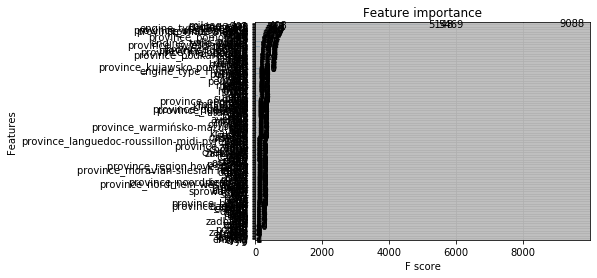

In [101]:
xgb.plot_importance(bst)

In [105]:
xgb.feature_importance()

AttributeError: module 'xgboost' has no attribute 'feature_importance'